In [53]:
import qutip
import tensornetwork as tn
from tensornetwork.visualization.graphviz import to_graphviz 
import qutip_tensornetwork as qtn
import numpy as np
from qutip_tensornetwork import data
from qutip_tensornetwork.quantum import QuOperator
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


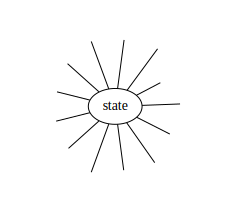

In [96]:
# In order to preserve the dimensions Qobj needs to be created form Quoperator
random_state = qutip.rand_ket(N=2**13, dims=[[2]*13,[1]*13])
random_state = random_state.full().reshape([2]*13)
random_state = tn.Node(random_state, name='state')
random_state = QuOperator(random_state[:], [])
random_state = qutip.Qobj(random_state, dims=[[2]*n,[2]*n])
to_graphviz(random_state.data._quoperator.nodes)

In [97]:
# Tensor is not included yet
h = qutip.operations.hadamard_transform().full()
h = tn.Node(h, "H")
h = QuOperator(h[0:1], h[1:])
h_f = h.tensor_product(h)
for _ in range(11):
    h_f = h_f.tensor_product(h)
h = qutip.Qobj(h_f,  dims=[[2]*n,[2]*n])

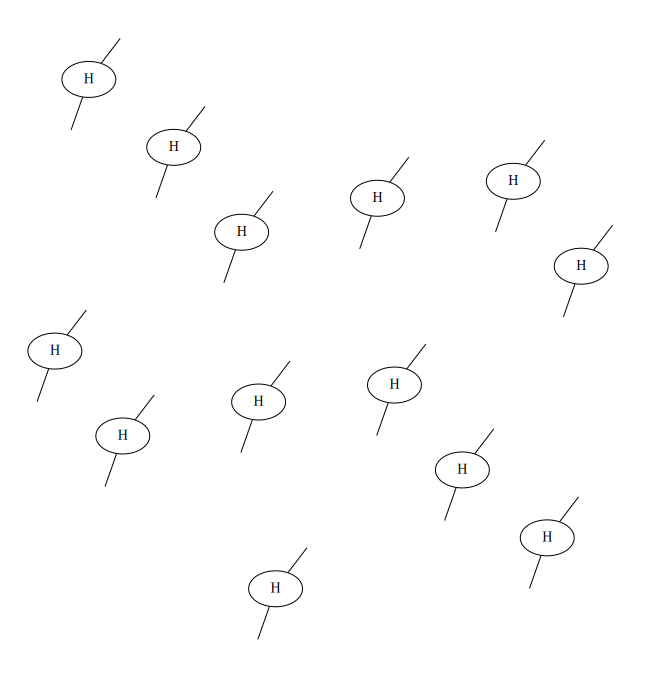

In [98]:
to_graphviz(h.data._quoperator.nodes)

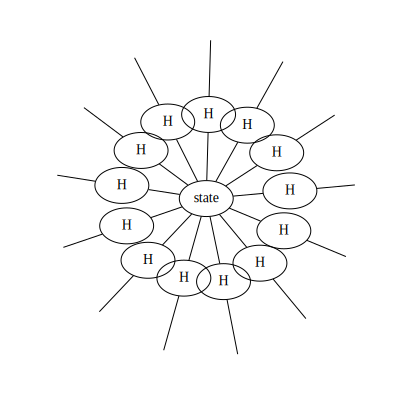

In [99]:
result =  h@random_state

to_graphviz(result.data._quoperator.nodes)

In [100]:
%%timeit
# I still need to think about the contractions. When do we do them?
# Probably when the output is a scalar?
# Here I do it manually
# The speed-up is lower than what I show in the blog.
# I am guessing there is a lot of overhed. Time is similar to the 
# "improved" sparse method (x3 slower actually)
# but with the advantage of improved memory 
# efficiency.
# Maybe a cython implementation of some operations could be useful?
# Not sure how much can be made into cython easily though.
# Also, I should look into profiling tools to get a better
# Idea of what is going on. Maybe for larger graphs the reative overhead 
# gets reduced?
result =  h@random_state
result.data._quoperator.contract()

3.32 ms ± 44.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


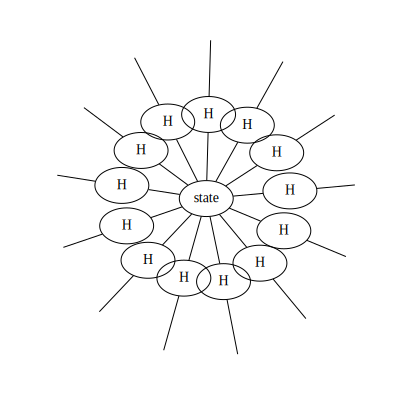

In [101]:
to_graphviz(result.data._quoperator.nodes)

In [102]:
# btw, visualization of qobj would also contract (to_array contracts).
# We could potentilly change it to output the graph by default but 
# graphs are not perferct. Usually a bit messy (see above graph)
# for hadamrds.  Ignore the "This has changed" if it appears.
result

Quantum object: dims=[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]], shape=(8192, 1), type='oper', isherm=False
Qobj data =
[[ 0.01070513+0.00456543j]
 [ 0.00918151+0.00536064j]
 [-0.00297457+0.0035311j ]
 ...
 [-0.00889425-0.00822487j]
 [-0.01479257-0.01206416j]
 [-0.0018504 +0.00066053j]]

In [103]:
# Same but with dense.
random_state = random_state.to('dense')
h = h.to('dense')

In [104]:
%%timeit 
result_dense = h*random_state 

64.4 ms ± 1.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [105]:
n = 13
H = qutip.operations.hadamard_transform()  # One qubit hadamard
O = qutip.tensor([H]*n)
state = qutip.rand_ket(2**n, dims=[[2]*n,[1]*n])


In [106]:
%%timeit # 125 ms
result = O*random_state

64.7 ms ± 1.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [107]:
state

Quantum object: dims=[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], shape=(8192, 1), type='ket'
Qobj data =
[[ 0.01324774+0.0016742j ]
 [-0.01340024+0.00492152j]
 [-0.0075554 -0.00772242j]
 ...
 [ 0.01305972-0.00354158j]
 [-0.00597917+0.01243224j]
 [-0.01236105-0.00757404j]]

In [108]:
random_state

Quantum object: dims=[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]], shape=(8192, 1), type='oper', isherm=False
Qobj data =
[[-0.00310257+0.0077465j ]
 [-0.00178776+0.0113339j ]
 [ 0.00197514-0.00042702j]
 ...
 [-0.01148803+0.01038549j]
 [ 0.00847327-0.00801102j]
 [-0.00264988+0.00300764j]]

In [110]:
h.data

Dense(shape=(8192, 8192), fortran=False)